In [1]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
sns.set(style='ticks', context='paper', font='CMU Sans Serif')

In [2]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

In [3]:
def create_record(mix):
    file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
    }
    file2dist = {
        '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
        '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
        '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
    }
    file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }

    mix_id = mix['id']
    mix_dir = f'../data/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    # Accuracy metrics
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    df_pmn_mc = pd.read_csv(f'{mix_dir}/pmn-mc/records.csv')
    was__ns3__pmn_m = wasserstein_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    was__ns3__pmn_mc = wasserstein_distance(df_ns3['slowdown'], df_pmn_mc['slowdown'])
    p99__ns3__pmn_mc = p99_distance(df_ns3['slowdown'], df_pmn_mc['slowdown'])

    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        'was__ns3__pmn_m': was__ns3__pmn_m,
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        'was__ns3__pmn_mc': was__ns3__pmn_mc,
        'p99__ns3__pmn_mc': p99__ns3__pmn_mc,
    }
    return record
    
def get_records():
    mix_file = '../spec/all.mix.json'
    csv_file = 'sensitivity.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv('sensitivity.csv', index=False)
    return mixes

records = get_records()

## Max load

### CDFs

In [4]:
def ecdfplot(df, x):
    df['pct'] = df.groupby(by=['kind'], as_index=False)[x].rank(pct=True)
    plt.figure(figsize=(4, 1.5))
    ax = sns.lineplot(data=df, x=x, y='pct', hue='kind', style='kind', ci=None)
    ax.get_legend().set_title('Max load (top 10% avg)')
    ax.get_legend().set_frame_on(False)
    sns.despine()
    plt.ylabel('CDF')
    
def percentify(x):
    return f'{int(round(x, 2) * 100)}%'


In [5]:
print(records['max_load'].min())
print(records['max_load'].max())

0.2575055316501516
0.8263943503041119


In [6]:
records = records.sort_values(by='max_load')
n = round(len(records) / 3)
records_l = records.iloc[0:n].copy()
records_m = records.iloc[n:n+n].copy()
records_h = records.iloc[n+n:].copy()
# records_l = records[records['max_load'] <= 0.5].copy()
# records_m = records[records['max_load'] <= 0.65].copy()
# records_h = records[records['max_load'] <= 1.0].copy()
max_load = records['max_load'].max()

max_load_l_min = records_l['max_load'].min()
max_load_m_min = records_m['max_load'].min()
max_load_h_min = records_h['max_load'].min()

max_load_l_max = records_l['max_load'].max()
max_load_m_max = records_m['max_load'].max()
max_load_h_max = records_h['max_load'].max()

top10pct_load_l_min = records_l['top10pct_load'].min()
top10pct_load_m_min = records_m['top10pct_load'].min()
top10pct_load_h_min = records_h['top10pct_load'].min()

top10pct_load_l_max = records_l['top10pct_load'].max()
top10pct_load_m_max = records_m['top10pct_load'].max()
top10pct_load_h_max = records_h['top10pct_load'].max()

records_l.loc[:, 'kind'] = 'low'
records_m.loc[:, 'kind'] = 'medium'
records_h.loc[:, 'kind'] = 'high'
records.loc[:, 'kind'] = 'all'
records_lmh = pd.concat([records_l, records_h, records_m, records], ignore_index=True)

/tmp/ipykernel_1570781/851851297.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_m', y='pct', hue='kind', style='kind', ci=None)
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font 

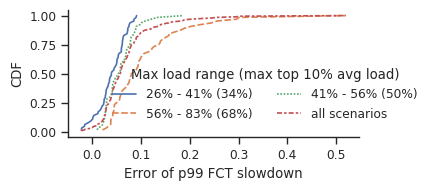

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)
records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)['p99__ns3__pmn_m'].rank(pct=True)
ax = sns.lineplot(data=records_lmh, x='p99__ns3__pmn_m', y='pct', hue='kind', style='kind', ci=None)
handles = ax.get_legend().get_lines()
ax.get_legend().remove()
title='Max load range (max top 10% avg load)'
labels=[
    f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
    f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
    f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
    'all scenarios'
]
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(handles=handles, labels=labels, title=title, loc='lower right', frameon=False, ncol=2, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-0.pdf', bbox_inches='tight')

###  Misc

In [8]:
records['p99__ns3__pmn_m'].max()
records['max_load'].quantile(0.6)
records_h['p99__ns3__pmn_m'].mean()
records[(records['oversub'] == '2-to-1') & (records['size_dist'] == 'WebServer') & (records['matrix'] == 'Matrix B')].sort_values(by='p99__ns3__pmn_m', ascending=False).iloc[:10]

,id,matrix,size_dist,lognorm_sigma,max_load_spec,max_load,top10pct_load,oversub,was__ns3__pmn_m,p99__ns3__pmn_m,was__ns3__pmn_mc,p99__ns3__pmn_mc,kind
63,63,Matrix B,WebServer,2.0,0.731133,0.736026,0.607602,2-to-1,0.430972,0.151472,0.426433,0.149045,all
74,74,Matrix B,WebServer,1.0,0.590949,0.592628,0.489232,2-to-1,0.206020,0.094396,0.201392,0.095593,all
168,168,Matrix B,WebServer,2.0,0.351868,0.354296,0.292478,2-to-1,0.076184,0.063541,0.068180,0.057592,all
24,24,Matrix B,WebServer,2.0,0.349409,0.351822,0.290436,2-to-1,0.075059,0.060389,0.067367,0.054279,all
183,183,Matrix B,WebServer,2.0,0.466966,0.470191,0.388151,2-to-1,0.129231,0.058491,0.122964,0.059180,all
29,29,Matrix B,WebServer,1.0,0.518351,0.519585,0.428933,2-to-1,0.147329,0.058488,0.141568,0.059491,all
146,146,Matrix B,WebServer,2.0,0.487395,0.490803,0.405167,2-to-1,0.141892,0.058340,0.134701,0.057889,all
175,175,Matrix B,WebServer,1.0,0.491736,0.493031,0.407012,2-to-1,0.129447,0.054156,0.123122,0.051713,all
17,17,Matrix B,WebServer,2.0,0.259027,0.260839,0.215327,2-to-1,0.047850,0.048037,0.043501,0.044337,all
68,68,Matrix B,WebServer,2.0,0.255738,0.257506,0.212575,2-to-1,0.047104,0.045782,0.042025,0.039938,all


### Less than 10% error?

In [9]:
pct_lt_10_l = len(records_l[records_l['p99__ns3__pmn_m'] <= 0.1]) / len(records_l)
pct_lt_10_m = len(records_m[records_m['p99__ns3__pmn_m'] <= 0.1]) / len(records_m)
pct_lt_10_h = len(records_h[records_h['p99__ns3__pmn_m'] <= 0.1]) / len(records_h)
pct_lt_10 = len(records[records['p99__ns3__pmn_m'] <= 0.1]) / len(records)
print(f'low: {percentify(pct_lt_10_l)}')
print(f'med: {percentify(pct_lt_10_m)}')
print(f'high: {percentify(pct_lt_10_h)}')
print(f'all: {percentify(pct_lt_10)}')

records_lm = pd.concat([records_l, records_m])
pct_lt_10_lm = len(records_lm[records_lm['p99__ns3__pmn_m'] <= 0.1]) / len(records_lm)
print(f'low-to-med: {int(round(pct_lt_10_lm, 2) * 100)}%')


low: 100%
med: 92%
high: 62%
all: 85%
low-to-med: 96%


### Fails to bound?

In [10]:
lt_0 = records[records['p99__ns3__pmn_m'] < 0.0]
pct_lt_0 = len(lt_0) / len(records)
print(f'{int(round(pct_lt_0, 2) * 100)}%')
print(lt_0['p99__ns3__pmn_m'].min())

3%
-0.0211604834463695


## Everything else (fix moderate load)

In [11]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal σ)', [1.0, 2.0], 0),
    ]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3.4), sharey=True)
    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)
        ax = sns.violinplot(data=df, x=x, y='p99__ns3__pmn_m', order=order, ax=axs[j, k])
        ax.set_xlabel(label)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
        ax.set_ylabel('')
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown')
    fig.tight_layout()

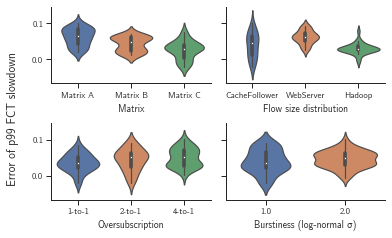

In [12]:
df_violin_lo = records[records['max_load'] <= records['max_load'].quantile(0.5)]
violins(df_violin_lo)
plt.savefig('figs/error-dist-1.pdf', bbox_inches='tight')

findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.
findfont: Font family 'CMU Sans Serif' not found.


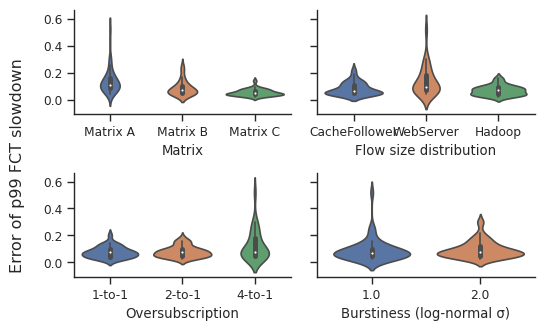

In [12]:
df_violin_hi = records[records['max_load'] > records['max_load'].quantile(0.5)]
violins(df_violin_hi)
plt.savefig('figs/error-dist-2.pdf', bbox_inches='tight')

## Scratch

In [13]:
alt.Chart(records).mark_point().encode(
    x=alt.X('max_load:Q'),
    y=alt.Y('p99__ns3__pmn_m:Q'),
    color=alt.Color('matrix:N'),
    shape=alt.Shape('size_dist:N'),
    size=alt.Size('lognorm_sigma:N'),
    opacity=alt.Opacity('oversub:N'),
    tooltip='id:N'
)

alt.Chart(...)